In [1]:
import pandas as pd
from datetime import datetime
from zoe import find_latest, read_pickle, latest_map_data, find_previous, plot_study, plot_study_evolution

In [2]:
path, dt = find_latest('zoe_uk_active_cases_*.pickle', date_index=-2)
curr_date = pd.to_datetime(dt)
uk_active_cases = read_pickle(path)
print(path)
display(uk_active_cases)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-09_2021-07-09-18-02.pickle


,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,77380,None,None,86085.715275
2020-06-13,77381,None,None,79940.811469
2020-06-14,77382,None,None,74244.112992
2020-06-15,77383,None,None,68878.187593
2020-06-16,77384,None,None,64137.552455
...,...,...,...,...
2021-07-05,77768,None,None,389466.326507
2021-07-06,77769,None,None,401745.389447
2021-07-07,77770,None,None,412911.361108


In [3]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-07-08_2021-07-08-18-02.pickle


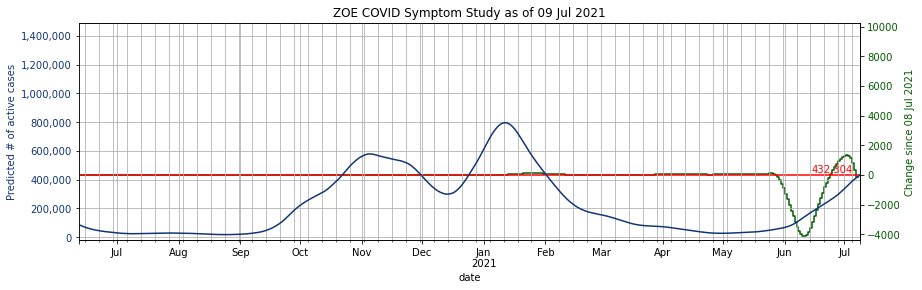

In [4]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

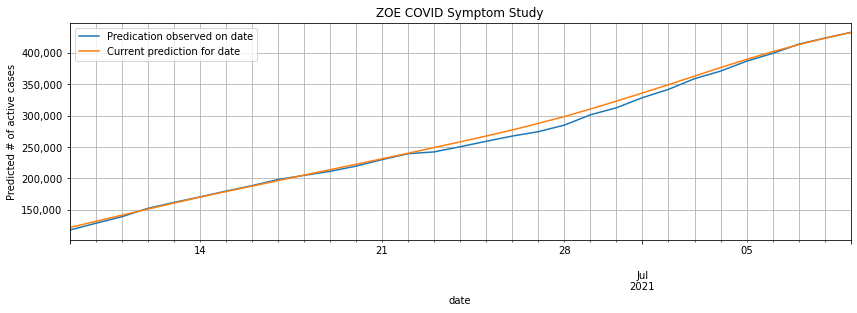

In [5]:
plot_study_evolution(curr_date, days=30)

In [6]:
for_date, prevalence_map = latest_map_data()
f'{for_date:%a %d %b %Y}'

'Fri 09 Jul 2021'

In [7]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
390,Dundee City,S12000042,3.352721
58,Eden,E07000030,2.805665
56,Carlisle,E07000028,2.414510
373,North Ayrshire,S12000021,2.341709
313,Aberdeen City,S12000033,2.145769
358,Belfast,N09000003,2.066498
309,Scottish Borders,S12000026,1.962975
277,St. Helens,E08000013,1.707305
317,Renfrewshire,S12000038,1.690578
324,East Dunbartonshire,S12000045,1.662022
